In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6527453324932057282
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 700186624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8630390327311795251
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-02-21 21:29:42.730856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 21:29:43.619275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 667 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:02:00.0, compute capability: 6.1


In [12]:
bar = tqdm(total=4)
bar.set_description("Raspakek data")

inputLines = np.load('traindata/inputLines.npy')/256
bar.update(1)

service = np.load('traindata/service.npy')
bar.update(1)

binaryData = np.load('traindata/binaryData.npy')
bar.update(1)

#blockL0 = np.load('traindata/blockL0.npy')
#bar.update(1)
#
#blockR0 = np.load('traindata/blockR0.npy')
#bar.update(1)
#
#blockL1 = np.load('traindata/blockL1.npy')
#bar.update(1)
#
#blockR1 = np.load('traindata/blockR1.npy')
#bar.update(1)
#
#blockL2 = np.load('traindata/blockL2.npy')
#bar.update(1)
#
#blockR2 = np.load('traindata/blockR2.npy')
#bar.update(1)

#target_data = {'service': service, 'blockL0': blockL0, 'blockR0':blockR0, 'blockL1':blockL1, 'blockR1':blockR1, 'blockL2':blockL2, 'blockR2':blockR2}
target_data = {'service': service, 'binaryData':binaryData}
bar.update(1)
bar.close()

Raspakek data: 100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


In [22]:
#remove all data after 100000 pos
if False:
    remAftr = 100000
    inputLines = inputLines[:remAftr]
    service = service[:remAftr]
    binaryData = binaryData[:remAftr]
    #blockL0 = blockL0[:remAftr]
    #blockR0 = blockR0[:remAftr]
    #blockL1 = blockL1[:remAftr]
    #blockR1 = blockR1[:remAftr]
    #blockL2 = blockL2[:remAftr]
    #blockR2 = blockR2[:remAftr]
    target_data = {'service': service, 'binaryData':binaryData}

In [7]:
inputLines.shape

(100000, 180)

In [8]:
binaryData[5151]

array([ True, False,  True, False, False,  True, False, False,  True,
       False,  True, False, False, False, False,  True,  True, False,
        True, False,  True, False, False,  True, False, False,  True,
       False,  True, False,  True, False, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True, False,  True,
       False, False, False,  True, False,  True,  True, False,  True,
       False, False, False, False,  True, False,  True,  True, False,
        True, False, False,  True, False, False,  True, False,  True,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True, False,  True, False,  True,  True, False, False,
       False,  True,

In [9]:
service[5151]

array([ True, False])

In [1]:
#model = keras.models.load_model("model")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180)]        0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 137)          24797       ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 137)          18906       ['dense_2[0][0]']                
                                                                                                  
 service (Dense)                (None, 2)            276         ['dense_3[0][0]']                
                                                                                              

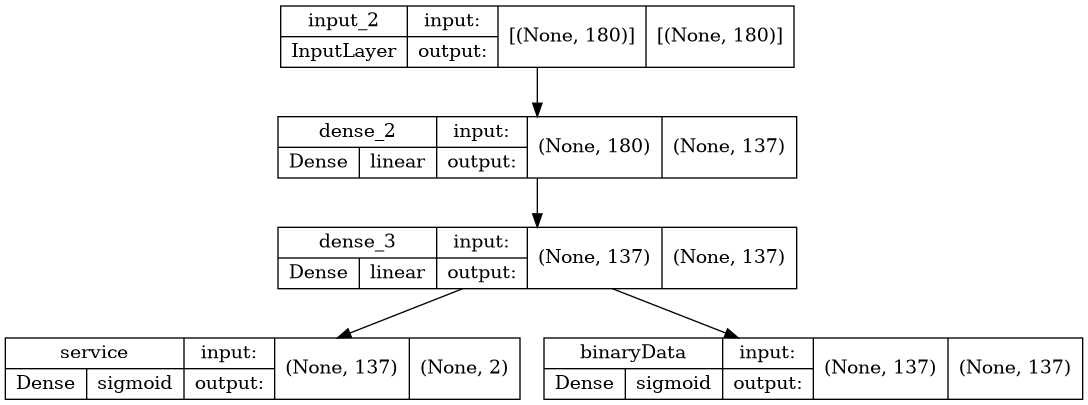

In [4]:
input = keras.Input(180, )
x = layers.Dense(137, activation='linear', use_bias=True, bias_initializer='zeros')(input)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(137, activation='linear', use_bias=True, bias_initializer='zeros')(x)

service = layers.Dense(2 , activation='sigmoid', name='service')(x)
binaryData = layers.Dense(137 , activation='sigmoid', name='binaryData')(x)
#blockL0 = layers.Dense(16, activation='sigmoid', use_bias=True, bias_initializer='zeros', name='blockL0')(x)
#blockR0 = layers.Dense(16, activation='sigmoid', use_bias=True, bias_initializer='zeros', name='blockR0')(x)
#blockL1 = layers.Dense(16, activation='sigmoid', use_bias=True, bias_initializer='zeros', name='blockL1')(x)
#blockR1 = layers.Dense(16, activation='sigmoid', use_bias=True, bias_initializer='zeros', name='blockR1')(x)
#blockL2 = layers.Dense(16, activation='sigmoid', use_bias=True, bias_initializer='zeros', name='blockL2')(x)
#blockR2 = layers.Dense(16, activation='sigmoid', use_bias=True, bias_initializer='zeros', name='blockR2')(x)


#model = keras.Model(input, [service, blockL0, blockR0, blockL1, blockR1, blockL2, blockR2])
model = keras.Model(input, [service, binaryData])


model.summary()

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

#visualizer(model, format='png', view=True)


In [19]:

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['binary_accuracy'])


In [23]:
model.fit(inputLines, target_data, epochs=3)

Epoch 1/3
3125/3125 [==============================] - 10s 3ms/step - loss: 9.0952e-05 - service_loss: 5.1650e-07 - binaryData_loss: 9.0435e-05 - service_binary_accuracy: 1.0000 - binaryData_binary_accuracy: 0.9999
Epoch 2/3
3125/3125 [==============================] - 9s 3ms/step - loss: 9.6874e-05 - service_loss: 2.6955e-06 - binaryData_loss: 9.4179e-05 - service_binary_accuracy: 1.0000 - binaryData_binary_accuracy: 0.9999
Epoch 3/3
3125/3125 [==============================] - 9s 3ms/step - loss: 7.0738e-05 - service_loss: 1.1275e-06 - binaryData_loss: 6.9611e-05 - service_binary_accuracy: 1.0000 - binaryData_binary_accuracy: 0.9999


In [24]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


In [26]:
print(model.predict(np.array([inputLines[50]])))

1/1 [==============================] - 0s 23ms/step
[array([[1.0000000e+00, 1.0801579e-21]], dtype=float32), array([[1.00000000e+00, 1.92762745e-19, 1.00000000e+00, 4.28436828e-19,
        1.11159402e-07, 2.68687960e-04, 3.31973268e-07, 9.99994636e-01,
        2.12208779e-05, 1.56515147e-04, 9.99988317e-01, 9.99957442e-01,
        6.46904591e-05, 9.99972105e-01, 9.99991655e-01, 9.99995232e-01,
        1.00000000e+00, 1.80244422e-06, 1.34083839e-05, 1.12535747e-06,
        9.99984264e-01, 8.25546635e-07, 9.39396341e-05, 4.46235708e-06,
        1.03089917e-06, 6.01457828e-07, 4.10345956e-06, 9.99999404e-01,
        9.99976516e-01, 9.99997735e-01, 4.80698918e-06, 9.99998212e-01,
        2.07853282e-05, 3.72497965e-07, 1.39415888e-05, 9.99999404e-01,
        5.62153730e-07, 9.99910355e-01, 9.99917746e-01, 1.12770488e-06,
        5.61367187e-07, 9.99992728e-01, 9.99998450e-01, 9.99999166e-01,
        3.68549968e-06, 9.99999762e-01, 1.12010239e-05, 3.86349768e-07,
        9.43090527e-07, 1.8